In [1]:
from imdbpie import Imdb
imdb = Imdb()
imdb = Imdb(anonymize=True) 
imdb = Imdb(cache=True)

from __future__ import division, print_function
import json
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV

%matplotlib inline



from IPython.core.display import HTML, Image

In [2]:
def get_top_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print(entry, res.status_code)
    else:
        print('.', end=" " )
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

def intminutes(x):
    y = x.replace('min', '').strip()
    return int(y)

def intvotes(x):
    y = x.replace(',', '').strip()
    return int(y)

def ratingCleaner(x):
    y = str(x).split()[0]
    if y == 'Rated':
        return str(x).split()[1]
    elif y == 'NOT':
        return x
    else:
        return y

def ratingCombiner(x):
    if x == 'M':
        return 'X'
    elif x == 'UNRATED':
        return 'NOT RATED'
    elif x == 'PASSED':
        return 'NOT RATED'
    elif x == 'N/A':
        return 'NOT RATED'
    elif x == 'APPROVED':
        return 'G'
    else:
        return x
    
def get_soup_from_url(url):
    '''Returns Beautiful Soup for a given webpage'''
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,'lxml')
    return soup

def get_movie_info(url):
    '''Takes in a movie's URL and scrapes that webpage using Beautiful Soup
    Returns a list of that movie's Title, Gross, Rating and Distributor
    '''
    soup = get_soup_from_url(url)
    results = []
    
    title_string = soup.find('h1').text
    title = str(title_string.split('(')[0].strip().encode('utf8'))
    userRatings = str(soup.find('span',{'itemprop':'reviewCount'}).text.split()[0])
    criticRatings = int(soup.find('span',{'itemprop':'reviewCount'}).findNextSibling().text.split()[0])
    
    results.append(title)
    results.append(userRatings)
    results.append(criticRatings)

    return results  

In [3]:
links=[]
dfimdb = pd.DataFrame(imdb.top_250())
top_250_url = 'http://www.imdb.com/chart/top?ref_=nv_mv_250_6'
soup_250= get_soup_from_url(top_250_url)

for x in dfimdb['tconst']:
    url1 = 'http://www.imdb.com/title/'
    url2 = '/?ref_=nv_sr_1'
    link = url1 + x + url2
    links.append(str(link))

In [4]:
table = []
for url in links:
    info = get_movie_info(url)
    table.append(info)

In [343]:
scrapeddf = pd.DataFrame(table, columns = ['Title','userRatings','criticRatings'])

In [344]:
entries = get_top_250()
len(entries)

250

In [345]:
entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [346]:
df = pd.DataFrame(entries_dict_list)

In [347]:
df = pd.merge(df, scrapeddf)

In [348]:
df = df.replace('N/A', np.nan)
df.isnull().sum()

Actors            0
Awards            5
Country           0
Director          0
Genre             0
Language          1
Metascore        78
Plot              0
Poster            0
Rated             1
Released          1
Response          0
Runtime           0
Title             0
Type              0
Writer            0
Year              0
imdbID            0
imdbRating        0
imdbVotes         0
userRatings       0
criticRatings     0
dtype: int64

In [349]:
df.Language.fillna('american', inplace=True)
df.Rated.fillna('NOT RATED', inplace=True)
df.Released = pd.to_datetime(df.Released)
df.Runtime = df.Runtime.apply(intminutes)
df.Year = df.Year.astype(int)
df.imdbRating = df.imdbRating.astype(float)
df.imdbVotes = df.imdbVotes.apply(intvotes)
df.userRatings = df.userRatings.apply(intvotes)
df.userRatings = df.userRatings.apply(lambda x: int(x))
df.criticRatings = df.criticRatings.apply(lambda x: int(x))
df['Rated'] = df['Rated'].apply(lambda x: ratingCleaner(x))
df['Rated'] = df['Rated'].apply(lambda x: ratingCombiner(x))
df.drop('Awards',1,inplace=True)
df.drop('Metascore',1,inplace=True)
df.drop('Poster',1,inplace=True)
df.drop('Released',1,inplace=True)
df.drop('Response',1,inplace=True)
df.drop('Type',1,inplace=True)
df.drop('Writer',1,inplace=True)
df.drop('imdbID',1,inplace=True)

In [352]:
cv = CountVectorizer()
data = cv.fit_transform(df.Genre).todense()
columns = ['genre_'+c for c in cv.get_feature_names()]
genredf = pd.DataFrame(data, columns=columns)

In [16]:
cv = CountVectorizer()
data = cv.fit_transform(df.Country).todense()
columns = ['country_'+c for c in cv.get_feature_names()]
countrydf = pd.DataFrame(data, columns=columns)

In [17]:
cv = CountVectorizer()
data = cv.fit_transform(df.Language).todense()
columns = ['language_'+c for c in cv.get_feature_names()]
languagedf = pd.DataFrame(data, columns=columns)

In [18]:
cv = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+')
data = cv.fit_transform(df.Actors).todense()
columns = ['actor: '+c for c in cv.get_feature_names()]
actorsdf = pd.DataFrame(data, columns=columns)

In [19]:
cv = CountVectorizer(token_pattern=u'(?u)\\w+\.?\\w?\.? \\w+')
data = cv.fit_transform(df.Director).todense()
columns = ['director: '+c for c in cv.get_feature_names()]
directorsdf = pd.DataFrame(data, columns=columns)

In [20]:
df = pd.concat([df, genredf], axis = 1)
df = pd.concat([df, countrydf], axis = 1)
df = pd.concat([df, languagedf], axis = 1)
df = pd.concat([df, actorsdf], axis = 1)
df = pd.concat([df, directorsdf], axis = 1)

In [30]:
df.drop('Genre',1,inplace=True)
df.drop('Country',1,inplace=True)
df.drop('Language',1,inplace=True)
df.drop('Actors',1,inplace=True)
df.drop('Director',1,inplace=True)

In [67]:
df.to_csv('NEWmovieInfo.csv', encoding='utf-8')

In [2]:
df = pd.read_csv('NEWmovieInfo.csv')

# Modeling!

In [3]:
df.drop('Unnamed: 0',1,inplace=True)

In [4]:
dummydf = df[['Rated']]
dummydf = pd.get_dummies(dummydf)

In [5]:
scalingdf = df[['Year','Runtime','userRatings','criticRatings','imdbVotes']]
scalingdf = MinMaxScaler().fit_transform(scalingdf.astype(float))
scalingdf = pd.DataFrame(scalingdf, columns = ['Year','Runtime','userRatings','criticRatings','imdbVotes'])

In [6]:
X = df.copy()
y = df['imdbRating']
yclassifier = df['imdbRating']
X.drop('Rated',1,inplace=True)
X.drop('Year',1,inplace=True)
X.drop('Runtime',1,inplace=True)
X.drop('userRatings',1,inplace=True)
X.drop('criticRatings',1,inplace=True)
X.drop('imdbVotes',1,inplace=True)
X.drop('Title',1,inplace=True)

In [7]:
tfidfvect = TfidfVectorizer(stop_words = 'english')
tfidfvect.fit(df['Plot'])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [8]:
nlpdf  = pd.DataFrame(tfidfvect.transform(df['Plot']).todense(),columns=tfidfvect.get_feature_names(),index=df['Plot'])
nlpdf.transpose().sort_values(df['Plot'][0], ascending=False).head(10).transpose()
nlpdf.reset_index(inplace=True)
nlpdf.drop('Plot',1,inplace = True)

In [9]:
X = pd.concat([X,dummydf,scalingdf], axis =1)
# X = pd.concat([X,dummydf,scalingdf,nlpdf], axis =1) # NLP analysis added
X.drop('imdbRating',1,inplace=True)
X.drop('Plot',1,inplace=True)

In [10]:
def bucketingY(x):
    if x >= 9.0:
        return 1
    elif x >= 8.5:
        return 2
    else:
        return 3

In [11]:
yclassifier = yclassifier.apply(lambda x: bucketingY(x))

# Trying feature selection

In [12]:
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor()

dt.fit(X,y)
rf.fit(X,y)
et.fit(X,y)
ab.fit(X,y)
gb.fit(X,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [13]:
dt_importances = pd.DataFrame(dt.feature_importances_,index=X.columns,
                           columns=['dt_importance']).sort_values('dt_importance',ascending=False)
dt_importances.head(10)

,dt_importance
imdbVotes,0.468066
Year,0.078546
criticRatings,0.071519
userRatings,0.057130
Runtime,0.033102
actor: eli wallach,0.031430
actor: john fiedler,0.031122
country_usa,0.028307
director: charles chaplin,0.023758
genre_action,0.013031


In [14]:
rf_importances = pd.DataFrame(rf.feature_importances_,index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',ascending=False)
rf_importances.head(10)

,rf_importance
imdbVotes,0.442318
Year,0.106490
userRatings,0.077306
criticRatings,0.062152
Runtime,0.029784
director: charles chaplin,0.019149
actor: eli wallach,0.018935
actor: aldo giuffrè,0.018055
actor: james stewart,0.007356
language_italian,0.006713


In [15]:
et_importances = pd.DataFrame(et.feature_importances_,index=X.columns,
                           columns=['et_importance']).sort_values('et_importance',ascending=False)
et_importances.head(10)

,et_importance
imdbVotes,0.331900
Year,0.042272
userRatings,0.041875
criticRatings,0.033233
director: francis ford,0.022154
director: charles chaplin,0.021221
language_sicilian,0.019622
genre_crime,0.017032
Rated_NOT RATED,0.016971
genre_drama,0.016125


In [16]:
ab_importances = pd.DataFrame(ab.feature_importances_,index=X.columns,
                           columns=['ab_importance']).sort_values('ab_importance',ascending=False)
ab_importances.head(10)

,ab_importance
imdbVotes,0.389697
Year,0.100247
userRatings,0.097254
Runtime,0.078057
criticRatings,0.071558
director: francis ford,0.032006
actor: e.g. marshall,0.019278
country_usa,0.017644
actor: martin balsam,0.016967
actor: lee j,0.016691


In [17]:
gb_importances = pd.DataFrame(gb.feature_importances_,index=X.columns,
                           columns=['gb_importance']).sort_values('gb_importance',ascending=False)
gb_importances.head(10)

,gb_importance
imdbVotes,0.145690
userRatings,0.084604
Year,0.078848
Runtime,0.054649
criticRatings,0.044569
director: sergio leone,0.020262
country_usa,0.019194
director: charles chaplin,0.018678
director: rob reiner,0.018642
country_japan,0.016417


In [21]:
newX = df[['imdbVotes','Year','userRatings','criticRatings','Runtime']]

# Let's take a quick look at how the decision trees look with both decision trees and bagging for regression and classification

In [115]:
clf = DecisionTreeRegressor(max_depth = 15)
bagger = BaggingRegressor(clf, max_features = 0.9)

print("DT Score:\t", cross_val_score(clf, X, y, cv=15, n_jobs=-1).mean())
print("Bagging Score:\t", cross_val_score(bagger, X, y, cv=10, n_jobs=-1).mean())

DT Score:	 -0.0601545822297
Bagging Score:	 0.372069894412


In [116]:
clfc = DecisionTreeClassifier(max_depth = 15)
baggerc = BaggingClassifier(clfc, max_features = 0.9)

print("DT Score:\t", cross_val_score(clf, X, yclassifier, cv=15, n_jobs=-1).mean())
print("Bagging Score:\t", cross_val_score(bagger, X, yclassifier, cv=10, n_jobs=-1).mean())

DT Score:	 -0.250969670984
Bagging Score:	 0.239825664184


# Regressors

In [134]:
cv = KFold(len(y), shuffle=True)

dt = DecisionTreeRegressor()
bdt = BaggingRegressor(DecisionTreeRegressor())
rf = RandomForestRegressor()
et = ExtraTreesRegressor()
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor()

def score(model, name):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

def do_plot(model, m=None):
    for fold, color in zip(cv, ['r', 'g', 'b']):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.scatter(y_test, y_pred, color=color)
        plt.plot([8.5,9.5],[8.5,9.5])
        plt.text(9,9.5, "R2: "+str(m), fontsize=20, )
    
score(dt, "Decision Tree")
score(bdt, "BaggingRegressor")
score(rf, "Random Forest")
score(et, "Extra Trees")
score(ab, "Adaboost ")
score(gb, "GradientBoosting")

Decision Tree Score:	0.157 ± 0.066
BaggingRegressor Score:	0.407 ± 0.098
Random Forest Score:	0.407 ± 0.095
Extra Trees Score:	0.32 ± 0.104
Adaboost  Score:	0.377 ± 0.056
GradientBoosting Score:	0.413 ± 0.073


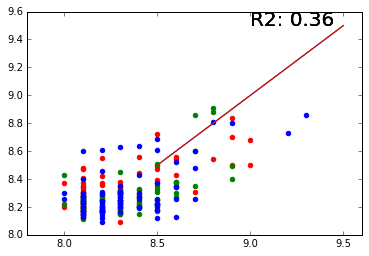

In [137]:
scores = cross_val_score(bdt, X, y, cv=cv)
do_plot(bdt, scores.mean().round(2))

# Grid search fo Decision Tree Regressor

In [128]:
PARAMETERS = {'max_depth':[3,5,10,20], 'max_features':[1,2,3,'auto'], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,3,5,7,10],
              'min_samples_split':[2,5,7]}
SCORING = 'mean_squared_error'

In [129]:
#Grid Search
model = DecisionTreeRegressor()
clf = GridSearchCV(model, PARAMETERS, scoring=SCORING, verbose=True, n_jobs=-1)
clf.fit(X, y)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   13.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 'auto'], 'max_leaf_nodes': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 7], 'max_depth': [3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=True)

In [130]:
#After completion, show the final best results and scores
print("Best model: \n \n {}".format(clf.best_estimator_))
print 
print("Best score was {}".format(clf.best_score_))
print(np.sqrt(-clf.best_score_))

Best model: 
 
 DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
           max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Best score was -0.0318064162505
0.178343534367


In [131]:
clf.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [132]:
clf.best_score_

-0.031806416250542612

Best score: 0.188743556608
Best depth: 4


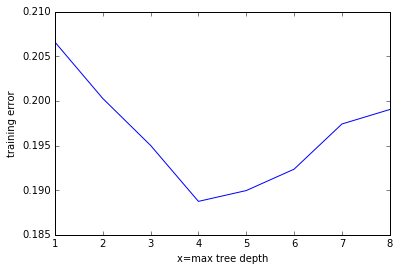

In [133]:
all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 9):
    treereg = DecisionTreeRegressor(max_depth=i, random_state=1)
    scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # If the score mean is better than the current best, or best is the default (-1), then update!
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print("Best score: %s" % best_score)
print("Best depth: %s" % best_depth)

# now actually fit the model
treereg = DecisionTreeRegressor(max_depth=best_depth, random_state=1)
treereg.fit(X, y)

plt.figure()
plt.plot(range(1, 9), all_scores)
plt.xlabel('x=max tree depth')
plt.ylabel('training error')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.3, random_state=42)
treereg = BaggingRegressor(DecisionTreeRegressor())
treereg.fit(X_train, y_train)
preds = treereg.predict(X_test)

In [34]:
cross_val_score(treereg, X, y, cv=cv, n_jobs=-1).mean()

0.35163593651511799

In [35]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.6000670443498376

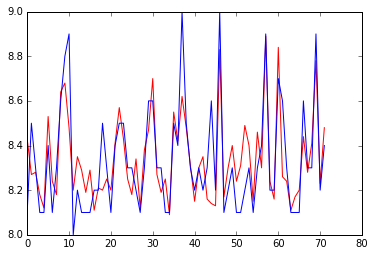

In [36]:
plt.plot(preds, color = 'red')
plt.plot(y_test.values)

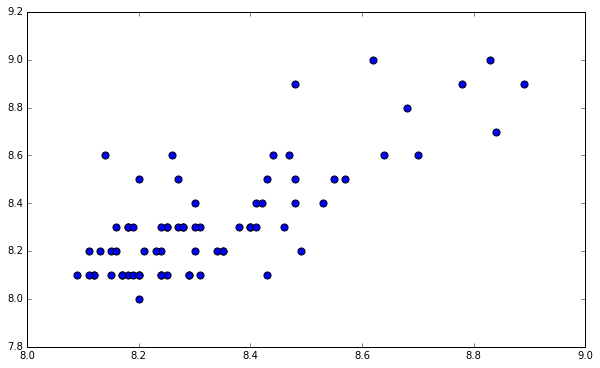

In [126]:
plt.figure(figsize=(10,6))

plt.scatter(preds, y_test, s=50);

http://changmichael.github.io/Picking_Favorites/